<a href="https://colab.research.google.com/github/aliceechen1206/sales-predictions/blob/main/Sales_Predication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **Sales Predication**

By: *Alice Chen*


In [ ]:
#Import Library 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
set_config(display='diagram')

In [ ]:
#Load Data
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# **Cleaning Data**

In [ ]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
#Check for Duplicates
df.duplicated().sum()

0

In [ ]:
#Check for Missing Value
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are missing value for Item Weight and Outlet Size. To address the missing value I will using mean average for the floats in Item Weight.

In [ ]:
weight_mean = df['Item_Weight'].mean()
df['Item_Weight'].fillna(weight_mean, inplace=True)
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

For the missing value in Outlet Size, I will first check how the category is spread out and how many stores are missing their Outlet Size and fill it with small

In [ ]:
df.groupby(['Outlet_Type', 'Outlet_Size'])['Item_Identifier'].count()

Outlet_Type        Outlet_Size
Grocery Store      Small           528
Supermarket Type1  High            932
                   Medium          930
                   Small          1860
Supermarket Type2  Medium          928
Supermarket Type3  Medium          935
Name: Item_Identifier, dtype: int64

In [ ]:
missing_mask = df['Outlet_Size'].isna()
mapping_dict = dict({'Grocery Store': 'Small', 'Supermarket Type2' : 'Medium', 'Supermarket Type3' : 'Medium'})
df.loc[missing_mask, 'Outlet_Size'] = df.loc[missing_mask, 'Outlet_Type'].map(mapping_dict)
df['Outlet_Size'] = df['Outlet_Size'].fillna('Medium')

In [ ]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
#Fix any inconsistent categories
df.nunique()

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [ ]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace ('LF','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace ('low fat','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace ('reg','Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
#Obtain summary statistics of any numerical columns
df[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Item_Outlet_Sales']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# **Vizualization**

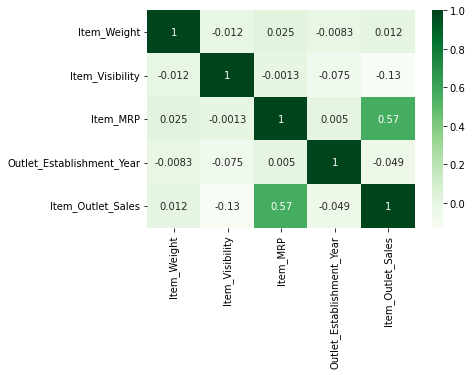

In [ ]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True)

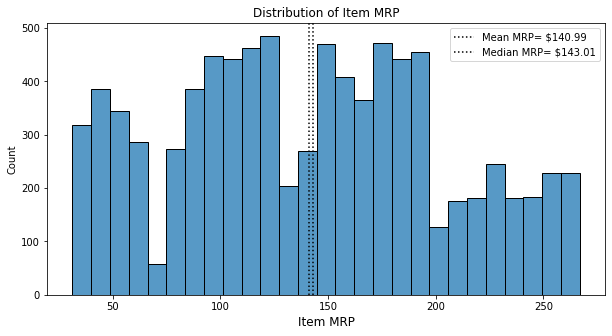

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=df, x='Item_MRP', ax=ax)
ax.set(title='Distribution of Item MRP')
ax.set_xlabel("Item MRP",
            fontsize='large');

mean_MRP = df['Item_MRP'].mean()
ax.axvline(mean_MRP,color='k', ls=':', 
           label=f"Mean MRP= ${round(mean_MRP,2)}");

med_MRP = df['Item_MRP'].median()
ax.axvline(med_MRP,color='k', ls=':', 
           label=f"Median MRP= ${round(med_MRP,2)}");

ax.legend();

Text(0, 0.5, 'Sales')

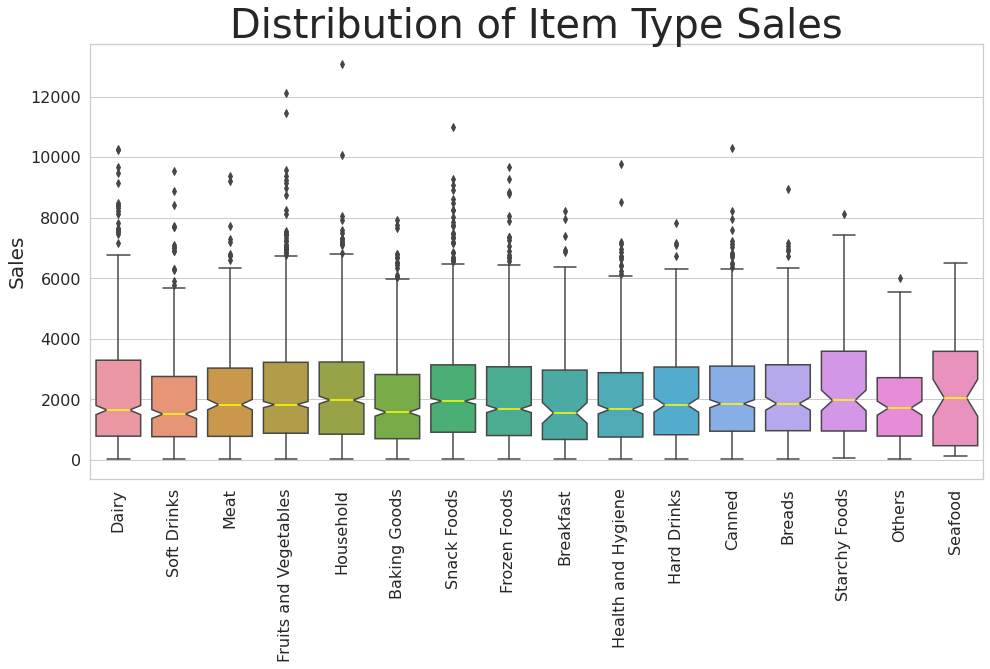

In [ ]:
# Boxplot of Item_Fat_Content vs Item_Sales
fig,axes = plt.subplots(figsize = (16,8))
plt.title('Distribution of Item Type Sales', fontsize = 40)
plt.xticks(rotation = 90, fontsize = 16) # Rotate x axis label 90 degrees
plt.yticks(fontsize = 16) 



sns.set_theme(style = 'whitegrid', palette = 'deep')
sns.boxplot(x = 'Item_Type',
            y = 'Item_Outlet_Sales',
            notch = True,
            showfliers = True, # Ignore Outliers ?
            data = df,
            medianprops = {'color':'yellow'})

plt.xlabel('', fontsize = 12); # Modify x axis label
plt.ylabel('Sales', fontsize = 20)

# **Prep for ML**

In [ ]:
#copy for ML
df_ml = df.copy()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
y=df_ml['Item_Outlet_Sales']
X=df_ml.drop(columns='Item_Outlet_Sales')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(6392, 11)

In [ ]:
display(X_train.info())
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            6392 non-null   object 
 1   Item_Weight                6392 non-null   float64
 2   Item_Fat_Content           6392 non-null   object 
 3   Item_Visibility            6392 non-null   float64
 4   Item_Type                  6392 non-null   object 
 5   Item_MRP                   6392 non-null   float64
 6   Outlet_Identifier          6392 non-null   object 
 7   Outlet_Establishment_Year  6392 non-null   int64  
 8   Outlet_Size                6392 non-null   object 
 9   Outlet_Location_Type       6392 non-null   object 
 10  Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 599.2+ KB


None

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,NCG06,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,FDV57,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,FDM27,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,FDG24,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,FDD05,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,Medium,Tier 2,Supermarket Type1


In [ ]:
num_cols = ['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']
cat_cols = ['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Location_Type','Outlet_Type']

In [ ]:
cat_selector = make_column_selector(dtype_include='object')

cat_cols = cat_selector(X_train)
cat_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [ ]:
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_train_cat = X_train[cat_cols].copy()
X_test_cat = X_test[cat_cols].copy()

ohe_encoder.fit(X_train_cat)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
X_train_ohe = ohe_encoder.transform(X_train_cat)
X_test_ohe = ohe_encoder.transform(X_test_cat)
X_train_ohe

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
ohe_col_names = ohe_encoder.get_feature_names_out(cat_cols)
ohe_col_names

array(['Item_Identifier_DRA12', 'Item_Identifier_DRA24',
       'Item_Identifier_DRA59', ..., 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [ ]:
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns = ohe_col_names)
X_train_ohe_df.reset_index(drop=True, inplace=True)

In [ ]:
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns = ohe_col_names)
X_test_ohe_df.reset_index(drop=True, inplace=True)

X_train_ohe_df

,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
num_selector = make_column_selector(dtype_include='number')

num_cols = num_selector(X_train)
num_cols

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [ ]:
scaler = StandardScaler()

X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

scaler.fit(X_train_num)

StandardScaler()

In [ ]:
num_train_scaled = scaler.transform(X_train_num)
num_test_scaled = scaler.transform(X_test_num)

num_train_scaled

array([[ 0.81916441, -0.71277507,  1.82810922,  1.32784893],
       [ 0.55825754, -1.29105225,  0.60336888,  1.32784893],
       [-0.12958785,  1.81331864,  0.24454056,  0.13618724],
       ...,
       [ 1.11564949, -0.92052713,  1.52302674,  0.49368575],
       [ 1.76791667, -0.2277552 , -0.38377708,  1.0895166 ],
       [ 0.81916441, -0.95867683, -0.73836105, -0.10214509]])

In [ ]:
num_train_scaled = pd.DataFrame(num_train_scaled, columns=num_cols)
num_train_scaled.reset_index(drop=True, inplace=True)

num_test_scaled = pd.DataFrame(num_test_scaled, columns=num_cols)
num_test_scaled.reset_index(drop=True, inplace=True)

In [ ]:
X_train_df = pd.concat([num_train_scaled, X_train_ohe_df], axis=1)
X_train_df

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.819164,-0.712775,1.828109,1.327849,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.558258,-1.291052,0.603369,1.327849,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.129588,1.813319,0.244541,0.136187,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.167286,-1.004931,-0.952591,0.732018,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.530729,-0.965484,-0.336460,0.493686,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,-0.830479,4.309657,-0.044657,0.017021,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6388,0.641273,1.008625,-1.058907,1.089517,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6389,1.115649,-0.920527,1.523027,0.493686,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6390,1.767917,-0.227755,-0.383777,1.089517,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy= 'mean')
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [ ]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [ ]:
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
preprocessor = make_column_transformer(number_tuple, category_tuple,remainder= 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f49a54bd2b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f49a54bd190>)])

In [ ]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f49a54bd2b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f49a54bd190>)])

In [ ]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 1592)




array([[ 0.81916441, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.55825754, -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12958785,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11564949, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76791667, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81916441, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

**Linear Regression Model**

In [ ]:
reg = LinearRegression()

In [ ]:
reg_pipe = make_pipeline(preprocessor, reg)

In [ ]:
reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f49a54bd2b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f49a54bd190>)])),
                ('linearregression', LinearRegression())])

In [ ]:
train_pred = reg_pipe.predict(X_train)
test_pred = reg_pipe.predict(X_test)

In [ ]:
#Evaluating R2 Score
train_r2 = np.corrcoef(y_train,train_pred)[0][1]**2
test_r2 = np.corrcoef(y_test, test_pred)[0][1]**2
print(f'Model Training R2: {train_r2}')
print(f'Model Testing R2: {test_r2}')

Model Training R2: 0.6715939060285185
Model Testing R2: 3.3670670528059e-06


In [ ]:
#Evaluating RMSE
train_RMSE=np.sqrt(np.mean(np.abs(train_pred-y_train)**2))
test_RMSE=np.sqrt(np.mean(test_pred-y_test)**2)
print(f'Model Training RMSE:{train_RMSE}')
print(f'Model Testing RMSE:{test_RMSE}')

Model Training RMSE:985.8522013513891
Model Testing RMSE:138913693735.8824


**Regression Tree Model**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

In [ ]:
#Evaluate R2 Socore and RMSE
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

1.0
0.22416476054175138


In [ ]:
depths = list(range(2, 36))
scores = pd.DataFrame(index = depths, columns=['Test Score','Train Score'])
for depth in depths:
  dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
  dec_tree.fit(X_train_processed,y_train)
  train_score = dec_tree.score(X_train_processed,y_train)
  test_score = dec_tree.score(X_test_processed,y_test)
  scores.loc[depth, 'Train Score']= train_score
  scores.loc[depth, 'Test Score']= test_score

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.596056,0.604207
6,0.584668,0.615702
4,0.583937,0.582705
7,0.577712,0.629269
8,0.561577,0.641334


In [ ]:
def eval_regression(true, pred):
  """Takes true and predicted values (arrays) and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(true, pred)
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'MAE {mae},\n MSE {mse},\n RMSE: {rmse},\n R^2: {r2} ')

In [ ]:
eval_regression(y_train, train_pred)

MAE 736.1796195244054,
 MSE 971904.56290938,
 RMSE: 985.8522013513891,
 R^2: 0.6715934753060069 


In [ ]:
eval_regression(y_test, test_pred)

MAE 197494876674.18417,
 MSE 9.16474108577151e+24,
 RMSE: 3027332338176.8823,
 R^2: -3.32178924642665e+18 


# **Conclusion**

With a negative R2 score, you can safely assume that the model is a very poor fit to the data and a super large RMSE will only confirm that.